## Estava interessado na Distribuição de séries e filmes da Netflix. Achei um dataset no Kaggle que coordena todos o conteúdo da Netflix(até fevereiro de 2020).Vou analisar algumas teorias sobre a distribuição e preparar os dados para serem utilizados em  um possível sistema de recomendação.

---


## Importando bibliotecas 

 Importando bibliotecas que vamos usar
 


In [242]:
import pandas as pd
from google.colab import files
import seaborn as sns
import matplotlib.pyplot as plt


##Funções utilizadas

In [277]:


def graficoFilme(dataset,contador,titulo,eixoX="",eixoY= "") :
  """
  Função recebe um dataset, uma coluna do dataset, o titulo do grafico bem como o titulo
  dos eixos.
  Retorna um grafico com os cinco principais valores presentes nas colunas
  """

  resultado =dataset[contador].str.get_dummies(",").sum().sort_values(ascending=False)[0:5] #pegando os cinco valores
  fig =plt.figure(figsize=(16,8)) #ajuste do grafico
  ax = fig.add_subplot(111)
  fig.subplots_adjust(top=0.90)

  # Título e eixos x e y
  fig.suptitle(titulo, fontsize=16, fontweight='bold')
  ax.set_xlabel(eixoX, fontsize=14, labelpad=20)
  ax.set_ylabel(eixoY, fontsize=14, labelpad=20)
  # Rotacionar os gêneros
  ax.tick_params(rotation=0) 

  sns.barplot(x=resultado.index,
              y=resultado.values,
              
              palette=sns.color_palette("BuGn_r", n_colors=len(resultado) + 4))
  plt.show()


In [ ]:


def graficoTop5(dataset,eixoX="",eixoY= "") :
  graficosData = []
  """
  Função recebe um dataset, uma coluna do dataset, o titulo do grafico bem como o titulo
  dos eixos.
  Retorna um grafico com os cinco principais valores presentes nas colunas
  """
  teste1 =dataset[eixoX].str.get_dummies(",").sum().sort_values(ascending=False)[0:5].index.tolist() #pegando os cinco valores

  resultado =dataset[eixoX].str.get_dummies(",")
  d1 = pd.concat([dataset,resultado],axis = 1).drop(columns = eixoX).reset_index(drop = True)

  d2 = d1.groupby(eixoY)[teste1].sum()
  b = d2.reset_index()
  df = b.melt(eixoY, var_name=eixoX,  value_name='Quantidade')

  g = sns.catplot(x=eixoX, y="Quantidade", hue=eixoY, data=df, kind='bar')
  g.fig.set_size_inches(18,8)


#Desenvolvimento

Vamos carregar os dados direito do Kaggle, para isso precisamos utilizar o json deles. Após baixar o arquivo kaggle.json da sua conta Kaggle(É necessario para baixar os dados) siga os passos abaixo para carregar o banco de dados.


In [244]:
files.upload() #Selecione o arquivo Json

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"arthurtorresbaio","key":"eb1b7e9073ede268854ec4009a4f4c66"}'}

Criando o diretório.

In [245]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json



Baixando o dataset diretamente do Kaggle


In [246]:
!kaggle datasets download -d shivamb/netflix-shows #baixando diretamente do endereço
!unzip /content/netflix-shows.zip #unzip os arquivos


netflix-shows.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/netflix-shows.zip
replace netflix_titles.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Vamos carregar os dados e mostrar os 5 primeiros valores para garantir que não houve um erro ao carregar os dados


In [329]:
dataNetflix = pd.read_csv("netflix_titles.csv") # carregando o arquivo
dataNetflix.head(5)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


##Análise Inicial


Vamos analisar os tipos de dados que temos para ter um norte para trabalhar.


In [330]:
dataNetflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


Temos a coluna "data_added" que se olharmos no dataset está verbosa. Eu gosto de transformar uma data em três colunas que indicam melhor a informação (dia,mês e ano) além de facilitar a visualização. Utilizando alguns comandos do python, podemos fazer tal operação


In [331]:
dataNetflix["date_added"] = pd.to_datetime(dataNetflix['date_added']) #transformando em formato para trabalhar.
dataNetflix["year_added"]  =(dataNetflix['date_added'].dt.year)
dataNetflix["month_added"] = (dataNetflix['date_added'].dt.month)
dataNetflix["day_added"] = (dataNetflix["date_added"].dt.day)
dataNetflix = dataNetflix.drop(columns = "date_added")


In [332]:
#dando uma olhada na nossa modificação
dataNetflix.head(5)

,show_id,type,title,director,cast,country,release_year,rating,duration,listed_in,description,year_added,month_added,day_added
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020.0,8.0,14.0
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016.0,12.0,23.0
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",2018.0,12.0,20.0
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",2017.0,11.0,16.0
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,2020.0,1.0,1.0


## Limpeza de Dados


Vamos ver se temos valores nulos no dataset e se forem muito relevantes o que se pode fazer para não perder esse dados.



In [333]:
dataNetflix.isna().sum()

show_id            0
type               0
title              0
director        2389
cast             718
country          507
release_year       0
rating             7
duration           0
listed_in          0
description        0
year_added        10
month_added       10
day_added         10
dtype: int64

Com uma rápida pesquisa, percebe-se que a maioria dos diretores faltantes(1969!) se refere a séries pois elas não tem um diretor definido para toda a duração da série.  Vamos substituir esses valores por Desconhecido.Além disso nota-se  que temos 11 linhas sem data na qual foi adicionada. Vamos identificar melhor essas colunas e analisar as 11 linhas para ver se temos algum padrão para a série não  ter a data que foi adicionada ao catálogo.

In [334]:

#Vamos trocar os valores Nulos por string's para podemos trabalhar melhor com os dados,
dataNetflix.loc[(dataNetflix["director"].isnull()),"director"] = "Diretor Desconhecido"
dataNetflix.loc[(dataNetflix["country"].isnull()) ,"country"] = "Pais Desconhecido"
dataNetflix.loc[(dataNetflix["cast"].isnull()) ,"cast"] = "Elenco Desconhecido"
dataNetflix.loc[(dataNetflix["rating"].isnull()) ,"rating"] = "Rating Desconhecido"


dataNetflix[dataNetflix.year_added.isna()]



,show_id,type,title,director,cast,country,release_year,rating,duration,listed_in,description,year_added,month_added,day_added
258,s259,TV Show,A Young Doctor's Notebook and Other Stories,Diretor Desconhecido,"Daniel Radcliffe, Jon Hamm, Adam Godley, Chris...",United Kingdom,2013,TV-MA,2 Seasons,"British TV Shows, TV Comedies, TV Dramas","Set during the Russian Revolution, this comic ...",NaN,NaN,NaN
549,s550,TV Show,Anthony Bourdain: Parts Unknown,Diretor Desconhecido,Anthony Bourdain,United States,2018,TV-PG,5 Seasons,Docuseries,This CNN original series has chef Anthony Bour...,NaN,NaN,NaN
2263,s2264,TV Show,Frasier,Diretor Desconhecido,"Kelsey Grammer, Jane Leeves, David Hyde Pierce...",United States,2003,TV-PG,11 Seasons,"Classic & Cult TV, TV Comedies",Frasier Crane is a snooty but lovable Seattle ...,NaN,NaN,NaN
2288,s2289,TV Show,Friends,Diretor Desconhecido,"Jennifer Aniston, Courteney Cox, Lisa Kudrow, ...",United States,2003,TV-14,10 Seasons,"Classic & Cult TV, TV Comedies",This hit sitcom follows the merry misadventure...,NaN,NaN,NaN
2555,s2556,TV Show,Gunslinger Girl,Diretor Desconhecido,"Yuuka Nanri, Kanako Mitsuhashi, Eri Sendai, Am...",Japan,2008,TV-14,2 Seasons,"Anime Series, Crime TV Shows","On the surface, the Social Welfare Agency appe...",NaN,NaN,NaN
3374,s3375,TV Show,Kikoriki,Diretor Desconhecido,Igor Dmitriev,Pais Desconhecido,2010,TV-Y,2 Seasons,Kids' TV,A wacky rabbit and his gang of animal pals hav...,NaN,NaN,NaN
3492,s3493,TV Show,La Familia P. Luche,Diretor Desconhecido,"Eugenio Derbez, Consuelo Duval, Luis Manuel Áv...",United States,2012,TV-14,3 Seasons,"International TV Shows, Spanish-Language TV Sh...","This irreverent sitcom featues Ludovico, Feder...",NaN,NaN,NaN
3946,s3947,TV Show,Maron,Diretor Desconhecido,"Marc Maron, Judd Hirsch, Josh Brener, Nora Zeh...",United States,2016,TV-MA,4 Seasons,TV Comedies,"Marc Maron stars as Marc Maron, who interviews...",NaN,NaN,NaN
5137,s5138,TV Show,Red vs. Blue,Diretor Desconhecido,"Burnie Burns, Jason Saldaña, Gustavo Sorola, G...",United States,2015,NR,13 Seasons,"TV Action & Adventure, TV Comedies, TV Sci-Fi ...","This parody of first-person shooter games, mil...",NaN,NaN,NaN
6065,s6066,TV Show,The Adventures of Figaro Pho,Diretor Desconhecido,"Luke Jurevicius, Craig Behenna, Charlotte Haml...",Australia,2015,TV-Y7,2 Seasons,"Kids' TV, TV Comedies","Imagine your worst fears, then multiply them: ...",NaN,NaN,NaN


Com uma olhada no dataset vemos que 10 dos 11 são Séries. E que uma delas é Friends, que é bem famosa então não podemos somente retirar tais dados. Utilizei a tática de complementar pela média das tabelas pois não afeta a distribuição .

In [335]:
dateInformation = ["year_added","month_added","day_added"] 

for date in dateInformation :
  dataNetflix[date] = dataNetflix[date].fillna(dataNetflix[date].mean()).astype(int)
  dataNetflix[date] = dataNetflix[date].map(int)
#vamos analisar os valores nulos agora
dataNetflix.isnull().sum()


show_id         0
type            0
title           0
director        0
cast            0
country         0
release_year    0
rating          0
duration        0
listed_in       0
description     0
year_added      0
month_added     0
day_added       0
dtype: int64

 Boa. Não temos valores nulos no nosso dataset agora. Podemos trabalhar melhor com esses dados.


Com o dataset Completo vamos mudar as colunas para Português para facilitar o entendimento. Vamos também criar uma variável para armazenar este dados, pois usaremos ele no final para criar o dataset auxiliar para o sistema de recomendação. O nome deste dataframe sera dataSisRecom






In [336]:
dataNetflix.columns=["Id","Tipo","Titulo","Diretor","Elenco",
              "Pais","Ano_Lancamento","Classificação_Indicativa","Duração",
              "Genero","Sinopse","Ano_Netflix","Mês_Netflix","Dia_Netflix"]

                                                    
dataSisRecom = dataNetflix.copy()



##Séries e Filmes tem muitas peculiariedades, vamos dividir o dataset em dois para trabalhar melhor com esses dados.

In [337]:
dataFilme = dataNetflix[dataNetflix["Tipo"] == "Movie"] # apenas os Filmes
dataSerie = dataNetflix[~(dataNetflix["Tipo"] == "Movie")] # apeans as Series

In [338]:
#Checagem
print(dataFilme.shape)
print(dataSerie.shape)


(5377, 14)
(2410, 14)


## Vamos trabalhar com filmes primeiros.



Vamos eliminar as colunas Id e Tipo por elas serem redudantes e não trazer nenhuma informação útil para visualização. É importante notar que podemos identificar o filme pelo Titulo


In [339]:
dataFilmeSimples =dataFilme.drop(columns = "Tipo")
dataFilmeSimples.reset_index(inplace = True)

Sabemos que todos os filmes estão classficiados em minutos, porém identificando esse padrão, pode-se retirar essa informação não util transformando esta coluna em inteiro para podemos ter uma disposição da duração de filmes na Netflix.
Depois vamos visualizar isto com um scatter plot.


In [340]:
dataFilmeSimples['Duração'] = dataFilmeSimples['Duração'].map(lambda x: x.rstrip('min')).astype(int) 


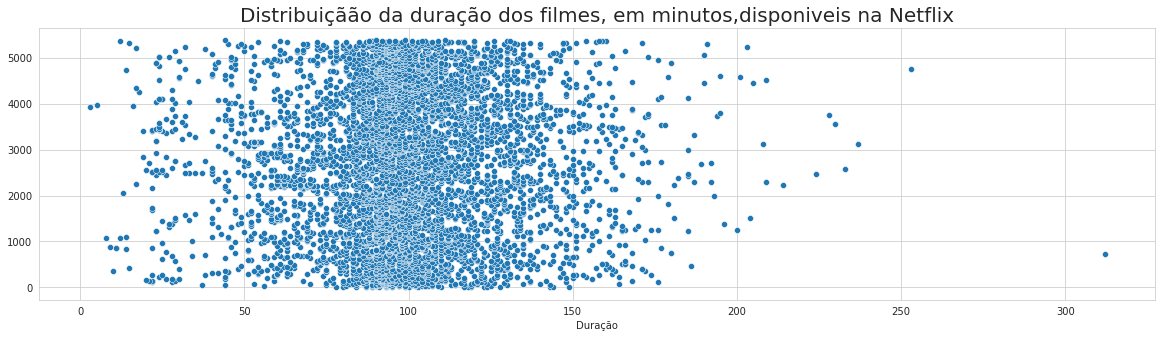

In [341]:

plt.figure(figsize=(20,5))
sns.set_style("whitegrid")
ax = sns.scatterplot(data =dataFilmeSimples, x="Duração" ,y =dataFilmeSimples.index)
ax.set_title("Distribuiçãão da duração dos filmes, em minutos,disponiveis na Netflix",
             {"fontsize" : 20, "fontweight" : 10});
              

Vemos que temos um filme com 300+ minutos. Um pouco de pesquisa revela que este filme é Bundersnatch. Também percebemos um filme com menos de 5 minutos. Este filme é Silent com uma duração de 3 minutos. Estes filmes podem ser considerados Outlines, pois distoam muito da distribuição esperada.



In [342]:
dataFilmeSimples[dataFilmeSimples.Duração == dataFilmeSimples.Duração.min()]


,index,Id,Titulo,Diretor,Elenco,Pais,Ano_Lancamento,Classificação_Indicativa,Duração,Genero,Sinopse,Ano_Netflix,Mês_Netflix,Dia_Netflix
3916,5605,s5606,Silent,"Limbert Fabian, Brandon Oldenburg",Elenco Desconhecido,United States,2014,TV-Y,3,"Children & Family Movies, Sci-Fi & Fantasy","""Silent"" is an animated short film created by ...",2019,6,4


A visualição entretanto não dá muita informação sobre a duração dos filmes em geral, sabemos que temos uma concentração entre 100-150 minutos. Vamos classificar os filmes em curta metragem(até 60 minutos) , média metragem(60-120 minutos), e longa-metragem( >120 minutos).




In [343]:
dataFilmeSimples.tipo_filme ="Valor" #criando a coluna data tipo_Filme
dataFilmeSimples.loc[(dataFilmeSimples["Duração"]<= 60 ),"tipo_filme"] = "Curta_metragem"
dataFilmeSimples.loc[(dataFilmeSimples["Duração"]> 60) & (dataFilmeSimples["Duração"] <=120),
                     "tipo_filme"] = "Media_metragem"
dataFilmeSimples.loc[(dataFilmeSimples["Duração"]> 120 ),"tipo_filme"] = "Longa_metragem"

Vamos ver a distribuição de filmes, esperamos uma grande número de Médias metragem e uma pequena quantidade de curtas e longas metragem

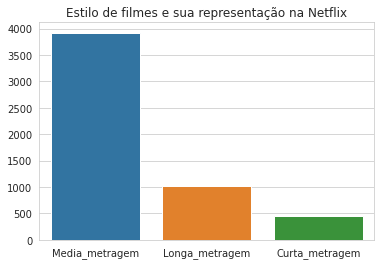

In [344]:
ax =sns.countplot(data =dataFilmeSimples,x="tipo_filme")
ax.set(xlabel='', ylabel='',title = "Estilo de filmes e sua representação na Netflix")
plt.show()

Vamos testar a função com Classificação indicativa.

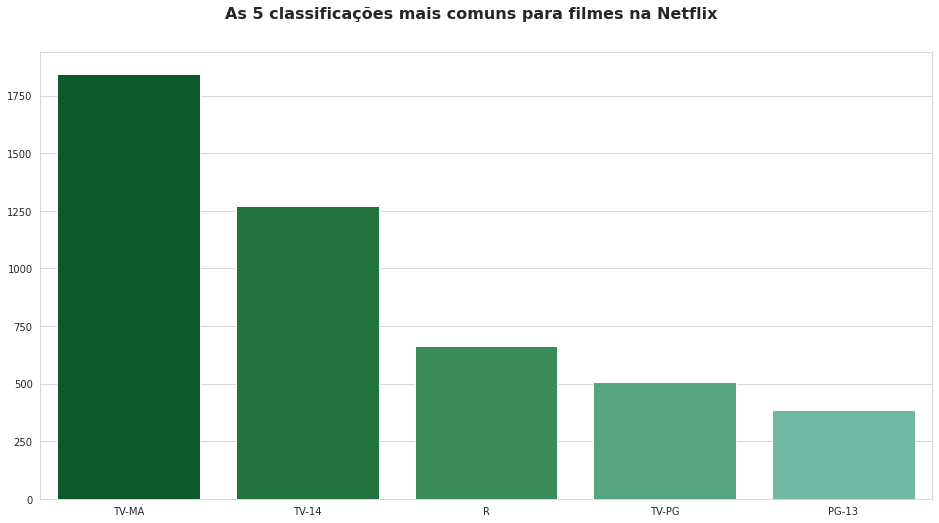

In [345]:
graficoFilme(dataFilmeSimples,"Classificação_Indicativa","As 5 classificações mais comuns para filmes na Netflix")

             


Vamos trabalhar um pouco com os Gêneros.

Vamos descobrir a sua distribuição dos 5 genêros Para isto vamos usar a função criada acima.


In [346]:
dataFilmeGenero =dataFilmeSimples.copy() #Copiando o arquivo pra facilitar
dataFilmeGenero.Genero= dataFilmeGenero.Genero.str.replace(", ", ",").str.replace(" ,",",")



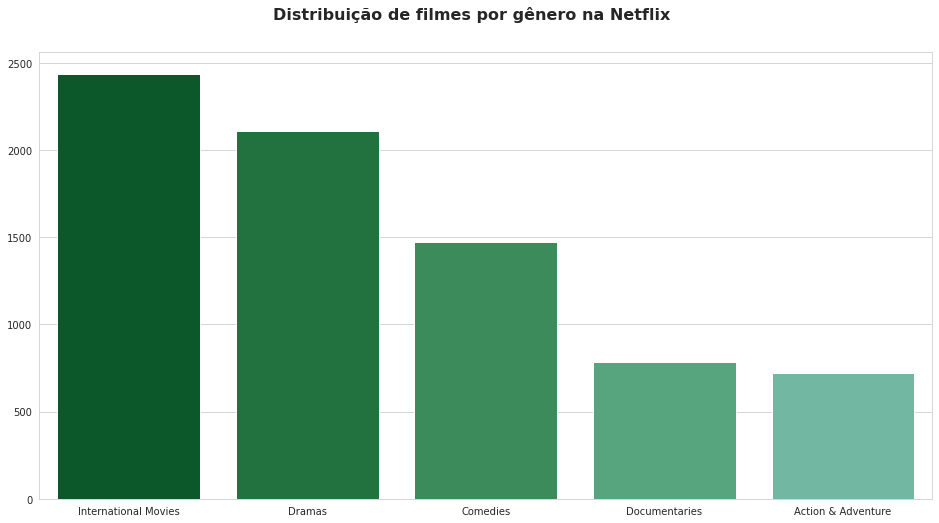

In [347]:
graficoFilme(dataFilmeGenero,"Genero","Distribuição de filmes por gênero na Netflix")

Para nossa surpresa  o gênero predominante na Netflix é de filmes Internacionais. Isto se deve, provavelmente, a um filme de Drama de um país não americano ser contado como International e Drama, ele está sendo contato em duas categorias. Vamos Analisar apenas filmes Internacionais.


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


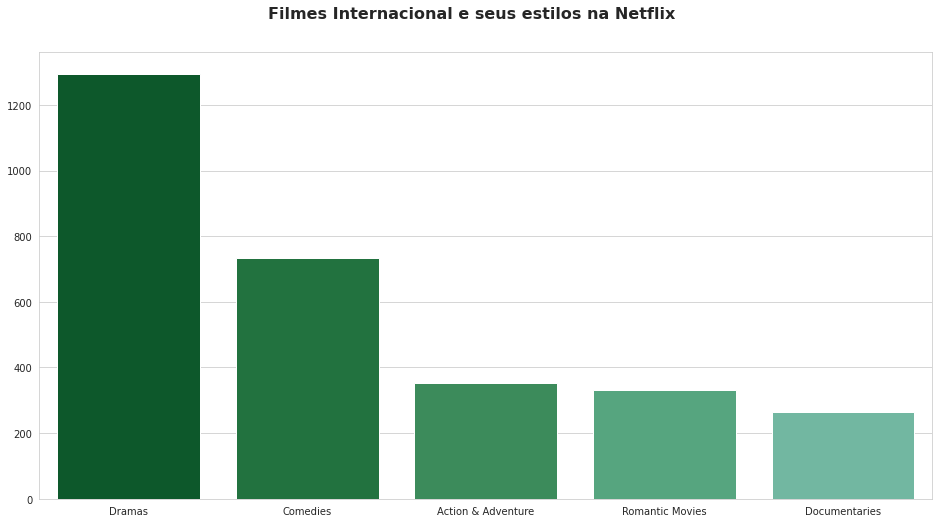

In [348]:
dataInternacional= dataFilmeGenero[dataFilmeGenero.Genero.str.contains("International Movies")];


dataInternacional.Genero =dataInternacional.Genero.str.replace(",International Movies","").str.replace("International Movies,","");

graficoFilme(dataInternacional,"Genero","Filmes Internacional e seus estilos na Netflix")

Voilá, Analisando apenas filmes Internacionais, percebe-se a maioria de Dramas e Comedias, como esperado. É importante notar que muitos dos filmes internacionais são filmes Indepedentes, o que mostra o suporte que a Netflix dá para este tipo de conteúdo.


##Vamos agora trabalhar com o dataframe de séries.

Vamos primeiro ver o estado do nosso dataframe


In [349]:

dataSerie.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2410 entries, 0 to 7785
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Id                        2410 non-null   object
 1   Tipo                      2410 non-null   object
 2   Titulo                    2410 non-null   object
 3   Diretor                   2410 non-null   object
 4   Elenco                    2410 non-null   object
 5   Pais                      2410 non-null   object
 6   Ano_Lancamento            2410 non-null   int64 
 7   Classificação_Indicativa  2410 non-null   object
 8   Duração                   2410 non-null   object
 9   Genero                    2410 non-null   object
 10  Sinopse                   2410 non-null   object
 11  Ano_Netflix               2410 non-null   int64 
 12  Mês_Netflix               2410 non-null   int64 
 13  Dia_Netflix               2410 non-null   int64 
dtypes: int64(4), object(10)


Sabemos que o Tipo é igual para todos bem como os diretores, e que Id não é uma informação util, podemos então retirar essas informações do nossa dataset. 
As colunas Gênero,Elenco e País apresenta o mesmo formato do dataset de filmes. Podemos então aplicar ideias usadas em filmes neste dataframe. Vamos tentar.



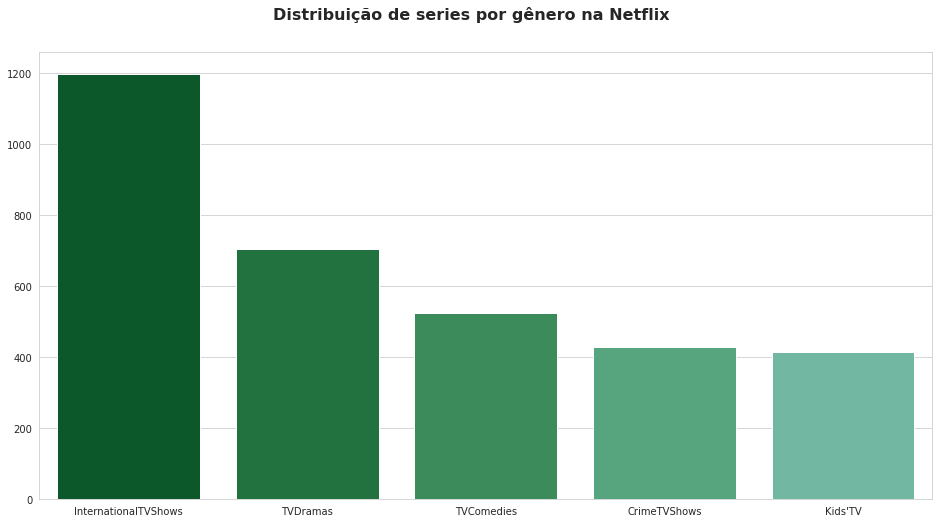

In [350]:
dataSerieLimpa = dataSerie.drop(columns=["Id","Tipo","Diretor"],axis = 1)
dataSerieLimpa.Genero =dataSerieLimpa.Genero.str.replace(",International Movies","").str.replace("International Movies,","").str.replace(" ","" );

graficoFilme(dataSerieLimpa,"Genero","Distribuição de series por gênero na Netflix")


Não supreendentemente, temos que o genero mais comum são series Internacionais. Uma surpresa que aparece entretanto é uma quantidade significante de serie para crianças(Kids' TV).


Vemos que os gêneros possuem TV e outras palavras que não acrescentam informação na sua descrição , podemos retirar para melhorar nossa visualização. Ademais, podemos fazer isso com a coluna "Duração", retirando a palavra "Season" e transformando para um inteiro

In [351]:

dataLimpissima = dataSerieLimpa.copy()
dataLimpissima['Duração'] = dataLimpissima['Duração'].map(lambda x: x.rstrip('Seasons')).astype(int)
dataLimpissima["Genero"] = dataLimpissima["Genero"].str.replace(" TV","").str.replace("TV","").str.replace("'","").str.replace("Shows","")


Vamos testar se nossa classificação deixar mais limpo o gráfico de Gênero x Número de Temporadas

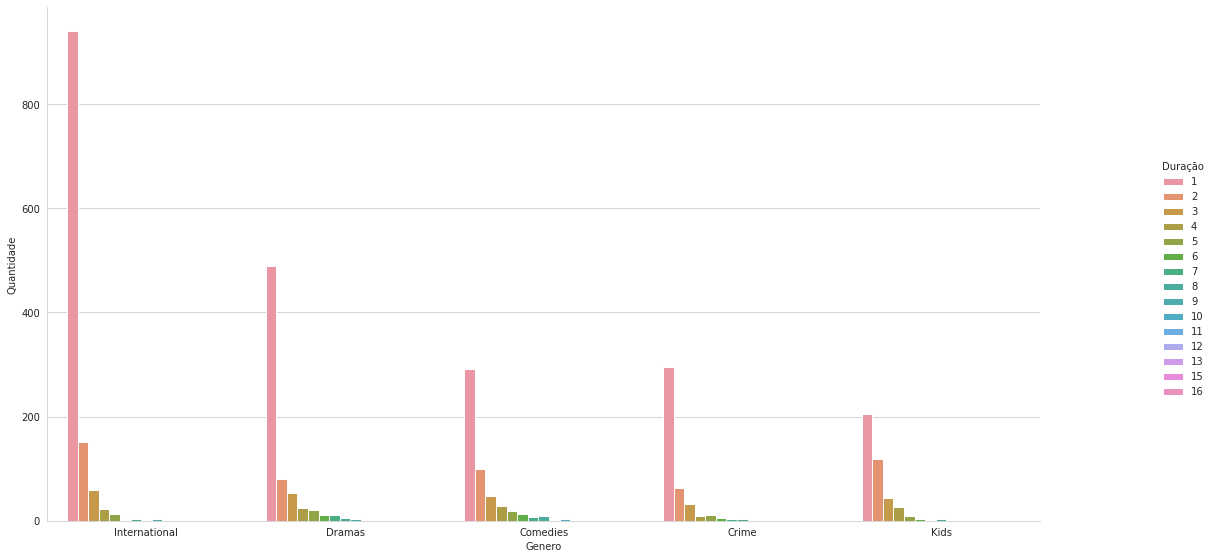

In [352]:
graficoTop5(dataLimpissima,"Genero","Duração")

O grafico ficou mais visivel entretanto podemos ver que a nossa legenda tem 15 valores( de uma temporada até 15 temporadas), isto faz com que o grafico não fique muito legivel. Outra coisa a se notar no grafico é que temos uma maioria esmagadora de series com poucas temporadas(1-3) do que o resto. Possiveis explicações são o fracasso de uma serie e que em uma temporada tambem são enquadradas mini-series, o que aumenta consideravelmente o numero de acontecimentos.


##Vamos por fim salvar o dataset original após a limpeza para podemos fazer um sistema de recomendação geral.


In [353]:
dataSisRecom.to_csv("dataNetflixLimpa.csv", index = False)

In [354]:
dataNet = pd.read_csv("/content/dataNetflixLimpa.csv")

dataNet.isnull().sum()

Id                          0
Tipo                        0
Titulo                      0
Diretor                     0
Elenco                      0
Pais                        0
Ano_Lancamento              0
Classificação_Indicativa    0
Duração                     0
Genero                      0
Sinopse                     0
Ano_Netflix                 0
Mês_Netflix                 0
Dia_Netflix                 0
dtype: int64